In [20]:
import pandas as pd
import joblib

clf = joblib.load("rf_area_classifier.pkl")

new_data = pd.read_csv("../2_Feature_Extraction/extract_features/tracking_features.csv")  
X_new = new_data.drop(columns=["tracking_id"])

new_data["predicted_label"] = clf.predict(X_new)
new_data.to_csv("new_tracking_predictions.csv", index=False)



<Axes: title={'center': 'Predicted Label Distribution'}, xlabel='predicted_label'>

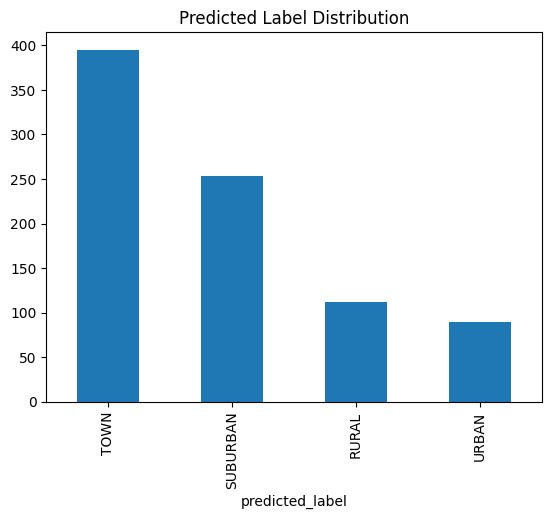

In [21]:
new_data["predicted_label"].value_counts().plot(kind="bar", title="Predicted Label Distribution")


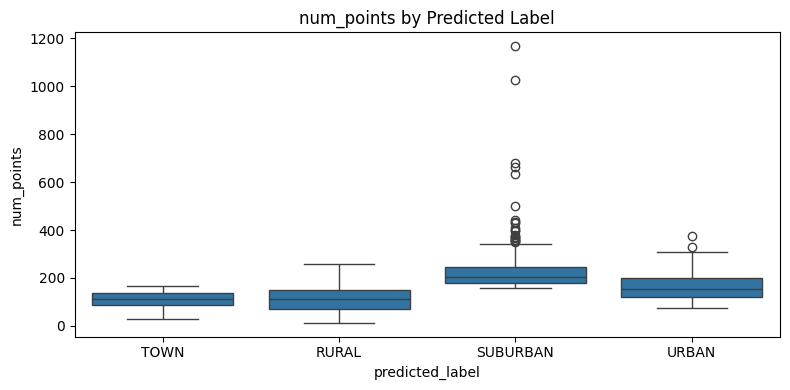

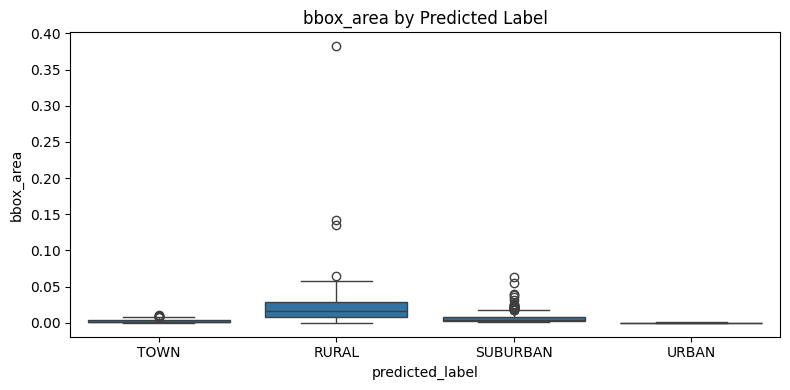

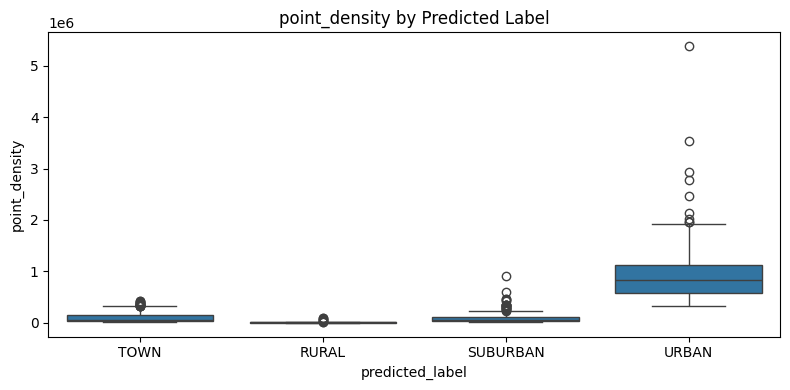

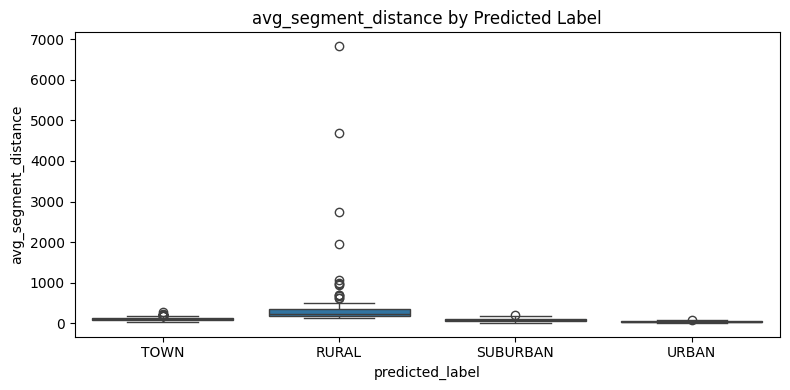

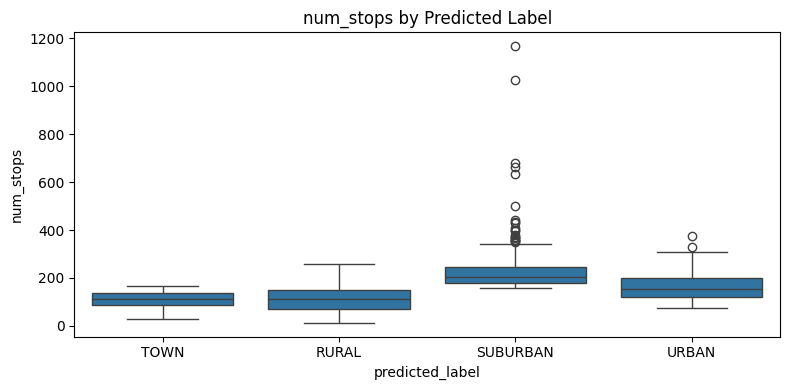

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ["num_points", "bbox_area", "point_density", "avg_segment_distance", "num_stops"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=new_data, x="predicted_label", y=feature)
    plt.title(f"{feature} by Predicted Label")
    plt.tight_layout()
    plt.show()


In [23]:
df = pd.read_csv("new_tracking_predictions.csv")

for label in df["predicted_label"].unique():
    print(f"\n=== {label} ===")
    display(df[df["predicted_label"] == label].sample(3, random_state=42))



=== TOWN ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
231,24409,94,0.003619,25968.383185,105.787504,94,TOWN
788,86872,151,0.001070,141046.252776,84.904546,151,TOWN
545,66909,146,0.001003,145428.188235,73.688992,146,TOWN



=== RURAL ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
95,6777,22,0.001128,19489.453541,355.717971,22,RURAL
196,20397,124,0.016808,7377.203502,205.543665,124,RURAL
18,1307,181,0.039018,4638.813793,202.511614,181,RURAL



=== SUBURBAN ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
757,84279,212,0.004118,51472.853161,174.609660,212,SUBURBAN
22,1458,230,0.000674,340499.638569,42.311294,230,SUBURBAN
313,31381,265,0.005556,47686.996945,87.085479,265,SUBURBAN



=== URBAN ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
401,40898,143,0.000196,725677.999270,66.362050,143,URBAN
253,26942,165,0.000464,354805.262818,51.425525,165,URBAN
529,65892,143,0.000335,425030.338191,43.202520,143,URBAN


/tmp/ipykernel_31847/1753934054.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]


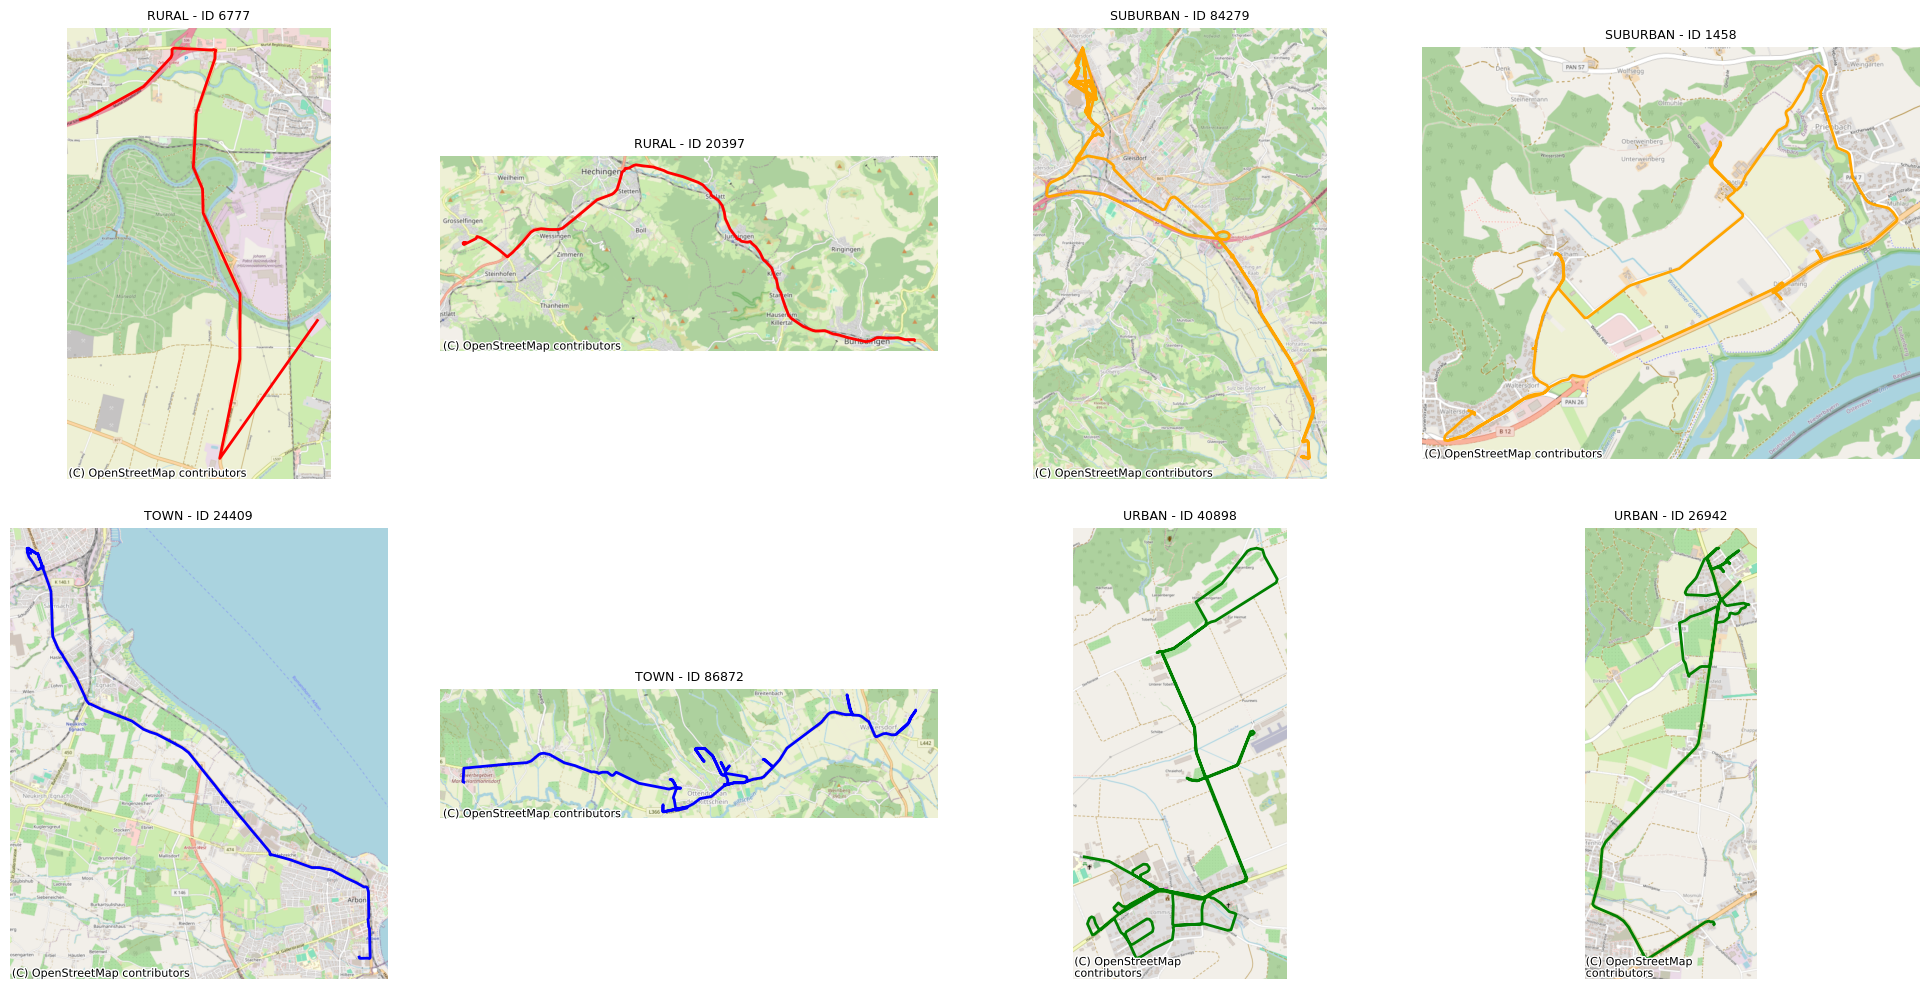

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString

predicted_df = pd.read_csv("new_tracking_predictions.csv")
waypoints_df = pd.read_parquet("../2_Feature_Extraction/data/filtered_waypoints.parquet")

sampled_ids = (
    predicted_df.groupby("predicted_label")
    .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]
    .explode()
    .tolist()
)

sampled_routes = waypoints_df[waypoints_df["id_tracking"].isin(sampled_ids)]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

color_map = {
    "RURAL": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "URBAN": "green"
}

for i, tracking_id in enumerate(sampled_ids):
    ax = axes[i]
    route = sampled_routes[sampled_routes["id_tracking"] == tracking_id].sort_values("sequence")
    coords = list(zip(route["longitude"], route["latitude"]))
    label = predicted_df[predicted_df["tracking_id"] == tracking_id]["predicted_label"].values[0]

    if len(coords) < 2:
        continue

    line = LineString(coords)
    gdf = gpd.GeoDataFrame(index=[0], geometry=[line], crs="EPSG:4326").to_crs(epsg=3857)

    gdf.plot(ax=ax, color=color_map.get(label, "gray"), linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{label} - ID {tracking_id}", fontsize=9)
    ax.set_axis_off()

for j in range(len(sampled_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig("Figures/predicted_tracking_routes_mapgrid.png", dpi=300)
plt.show()
